In [1]:
import sqlite3
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import pickle
import time
import re
from sklearn.model_selection import RandomizedSearchCV


: 

In [2]:
def load_data_from_db(db_path):
    conn = sqlite3.connect(db_path)
    df = pd.read_sql("SELECT * FROM reviews", conn)
    conn.close()
    return df

db_path = "artifacts/imdb_reviews.db"
df = load_data_from_db(db_path)
df.head()

,id,review_text,sentiment
0,1,One of the other reviewers has mentioned that ...,positive
1,2,A wonderful little production. <br /><br />The...,positive
2,3,I thought this was a wonderful way to spend ti...,positive
3,4,Basically there's a family where a little boy ...,negative
4,5,"Petter Mattei's ""Love in the Time of Money"" is...",positive


sentiment
positive    25000
negative    25000
Name: count, dtype: int64


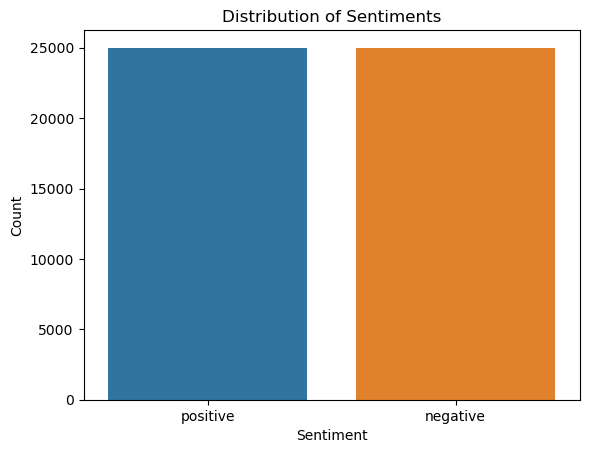

In [3]:
# checking the distribusion of sentiments

print(df["sentiment"].value_counts())
sns.countplot(data=df, x='sentiment')

plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Distribution of Sentiments')


plt.show()

sentiment
negative    1294.06436
positive    1324.79768
Name: review_length, dtype: float64


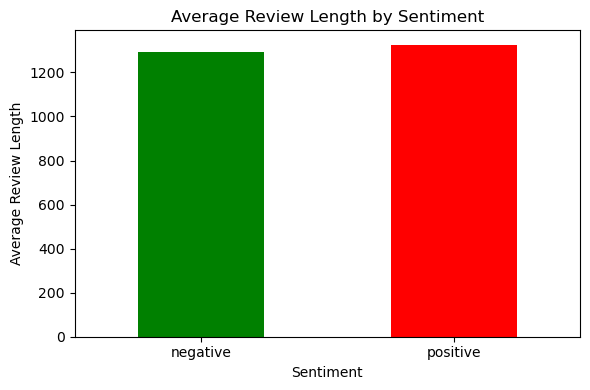

In [4]:
# Calculate review length
df['review_length'] = df['review_text'].apply(len)

# Group by sentiment and calculate average review length
average_lengths = df.groupby('sentiment')['review_length'].mean()
print(average_lengths)

plt.figure(figsize=(6, 4))
average_lengths.plot(kind='bar', color=['green', 'red'])
plt.title('Average Review Length by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Average Review Length')
plt.xticks(rotation=0)
plt.tight_layout()

# Show the plot
plt.show()

In [6]:
# Data Cleaning 
def clean_text(text):
    lemma = WordNetLemmatizer()
    swords = stopwords.words("english")

    text = re.sub(r"https\S+", "", text)
    text = re.sub("[^a-zA-Z0-9]", " ", text)
    text = nltk.word_tokenize(text.lower())
    text = [lemma.lemmatize(word) for word in text if word not in swords]
    return " ".join(text)
    
def preprocess_data(df):
    df["cleaned_text"] = df["review_text"].apply(clean_text)
    df['sentiment'] = df['sentiment'].str.lower().replace({'positive': 1, 'negative': 0})
    df.drop_duplicates(inplace=True)
    return df



In [7]:
cleaned_df = preprocess_data(df)
cleaned_df.head()


,id,review_text,sentiment,review_length,cleaned_text
0,1,One of the other reviewers has mentioned that ...,1,1761,one reviewer mentioned watching 1 oz episode h...
1,2,A wonderful little production. <br /><br />The...,1,998,wonderful little production br br filming tech...
2,3,I thought this was a wonderful way to spend ti...,1,926,thought wonderful way spend time hot summer we...
3,4,Basically there's a family where a little boy ...,0,748,basically family little boy jake think zombie ...
4,5,"Petter Mattei's ""Love in the Time of Money"" is...",1,1317,petter mattei love time money visually stunnin...


In [8]:
def train_test_valid_split(X,y, test_size=0.2, valid_size=0.2, random_state=None):
    """
    Splits the data into training, testing, and validation sets.
    """
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    # Split the training set into train and validation sets
    valid_size_adjusted = valid_size / (1 - test_size)  # Adjust validation size relative to training set
    X_train, X_valid, y_train, y_valid = train_test_split(
        X_train, y_train, test_size=valid_size_adjusted, random_state=random_state
    )

    return X_train, X_valid, X_test, y_train, y_valid, y_test


def vectorize_data(X_train, X_valid, X_test):

    tfidf_vectorizer = TfidfVectorizer()
    
    # Fit and transform the training data
    X_train_tf = tfidf_vectorizer.fit_transform(X_train)
    
    # Transform validation and test data
    X_valid_tf = tfidf_vectorizer.transform(X_valid)
    X_test_tf = tfidf_vectorizer.transform(X_test)
    

    return X_train_tf, X_valid_tf, X_test_tf, tfidf_vectorizer


In [9]:
X_train, X_valid, X_test, y_train, y_valid, y_test = train_test_valid_split(cleaned_df["cleaned_text"] ,cleaned_df["sentiment"], test_size=0.2, valid_size=0.2, random_state=None)
X_train_tf, X_valid_tf, X_test_tf, tfidf_vectorizer = vectorize_data(X_train, X_valid, X_test)



In [10]:

def train_model(X_train, y_train, model_type="LogisticRegression"):
    if model_type == "LogisticRegression":
        model =LogisticRegression()
    elif model_type == "naive_bayes":
        model = MultinomialNB()
    else:
        raise ValueError("Unsupported model type")

    model.fit(X_train, y_train)
    return model

def evaluate_model(model,X, y):
    predictions = model.predict(X)
    acc = accuracy_score(y, predictions)
    precision = precision_score(y, predictions)
    recall = recall_score(y, predictions)
    f1 = f1_score(y, predictions)

    print("Accuracy:", acc)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

    return classification_report(y, predictions)


In [11]:
log_reg = train_model(X_train_tf, y_train, model_type="LogisticRegression")
print(evaluate_model(log_reg,X_valid_tf, y_valid ))

Accuracy: 0.8931
Precision: 0.8810270482163858
Recall: 0.9067984668146056
F1 Score: 0.8937270106372402
              precision    recall  f1-score   support

           0       0.91      0.88      0.89      5043
           1       0.88      0.91      0.89      4957

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [13]:
nb = train_model(X_train_tf, y_train, model_type="naive_bayes")
print(evaluate_model(nb,X_valid_tf, y_valid ))

Accuracy: 0.8634
Precision: 0.8715083798882681
Recall: 0.8497074843655437
F1 Score: 0.8604698672114403
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      5043
           1       0.87      0.85      0.86      4957

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [ ]:
def perform_random_search(model, X_train, y_train, param_distributions, cv=5, n_jobs=-1, verbose=1):
    """
    Perform randomizedSearchCV on a pre-trained model.
    
    """
    # Initialize GridSearchCV with the given model and parameters
    random_search = RandomizedSearchCV(
        estimator=log_reg,
        param_distributions=param_distributions,
        n_iter=5,  # Number of parameter combinations to try
        scoring='accuracy',  # Scoring metric
        cv=5,  # Cross-validation splits
        verbose=2,
        random_state=42,
        n_jobs=-1
        )

    # Fit the grid search to the training data
    random_search.fit(X_train, y_train)

    # Get the best parameters and the best model
    best_params = random_search.best_params_
    best_model = random_search.best_estimator_

    # Return the best model and parameters
    return best_model, best_params


In [ ]:
param_distributions = {
    'C': np.logspace(-4, 4, 20),  # Regularization strength
    'penalty': ['l1', 'l2'],  # Penalty type
    'solver': ['liblinear', 'saga']  # Solvers compatible with l1/l2
}
perform_random_search(log_reg, X_train_tf, y_train,param_distributions=param_distributions, cv=5, n_jobs=-1, verbose=1)

In [14]:

def save_model(model, vectorizer, model_path, vectorizer_path):
    with open(model_path, "wb") as model_file:
        pickle.dump(model, model_file)

    with open(vectorizer_path, "wb") as vectorizer_file:
        pickle.dump(vectorizer, vectorizer_file)

def load_model(model_path, vectorizer_path):
    with open(model_path, "rb") as model_file:
        model = pickle.load(model_file)

    with open(vectorizer_path, "rb") as vectorizer_file:
        vectorizer = pickle.load(vectorizer_file)

    return model, vectorizer

In [17]:
save_model(log_reg,tfidf_vectorizer,"artifacts/model.pkl", "artifacts/vectorizer.pkl")